In [12]:
import requests
import time
import hashlib
from PIL import Image
import matplotlib.pyplot as plt

In [13]:
# INSERT HERE
public_key = os.environ['PUBLIC_KEY']
private_key = os.environ['PRIVATE_KEY']

In [14]:
def get_base_params(public_key, private_key):
    timestamp = str(time.time())
    hash_str = timestamp + private_key + public_key
    params = {
        "apikey": public_key,
        "hash": hashlib.md5(hash_str.encode()).hexdigest(),
        "ts": timestamp
    }
    return params

def build_params(public_key, private_key, payload):
    base_params = get_base_params(public_key, private_key)
    params = {**base_params,**payload}
    return params

def build_url(*args):
    args = [str(arg) for arg in args]
    return '/'.join(args)

# Obtain the same information for all other characters she's worked with in other comics
def get_character_details(character_name_or_id):
    if str(character_name_or_id).isdigit():
        # Given ID
        characters_url = build_url(base_url,'characters',character_name_or_id)
        params = get_base_params(public_key, private_key)
    else:
        # Given name
        characters_url = build_url(base_url,'characters')
        params = build_params(public_key, private_key, {'name': character_name_or_id})
    
    response = requests.get(characters_url, params=params)
    json_response = response.json()
    
    # Get name (they actually don't explicitly provide a 'real name' field...)
    # Loop through their urls until you find the 'wiki' one. Split the url for the name (it's not 100% formatted correctly all the time)
    result = json_response['data']['results'][0]
    character_name = result['name']
    real_name = character_name
    for i in result['urls']:
        if i['type'] == 'wiki':
            real_name = i['url'].split("?")[0].split("/")[-1]
    character_id = result['id']
    character_description = result['description']
    thumbnail_path = result['thumbnail']['path']
    thumbnail_extension = result['thumbnail']['extension']
    full_thumbnail_path = '.'.join([thumbnail_path,thumbnail_extension])
    
    return character_id, character_name, real_name, character_description, full_thumbnail_path, json_response


In [15]:
base_url = 'http://gateway.marvel.com/v1/public'
character = 'Spectrum'

## Obtain the name, id, description, and picture of Spectrum

Character name: Spectrum
Real name: Rambeau,_Monica
ID: 1010705
Description: 


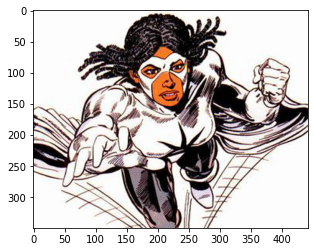

In [17]:
character_id, character_name, real_name, character_description, full_thumbnail_path, json_response = get_character_details(character)
# So the API response doesn't actually have a field for their real name...
# But according to the Marvel page, Spectrum's real name is Monica Ranbeau

print("Character name: {}".format(character))
print("Real name: {}".format(real_name))
print("ID: {}".format(character_id))
print("Description: {}".format(character_description)) # it's actually empty...
im = Image.open(requests.get(full_thumbnail_path, stream=True).raw)
plt.imshow(im)

## Get list of all characters Spectrum has worked with in her comics

In [20]:
# Go through each of her comics, and get characters from each comic
Spectrum_comics_list = json_response['data']['results'][0]['comics']['items']
character_list = set()
for comic in Spectrum_comics_list:
    comic_id = comic['resourceURI'].split("/")[-1]
    comic_characters_url = build_url(base_url, "comics/{}/characters".format(comic_id))
    comic_character_list = requests.get(comic_characters_url, params=get_base_params(public_key, private_key))
    json_results = comic_character_list.json()
    for character in json_results['data']['results']:
        character_list.add(character['id'])
        
# You can combine these top and bottom loops if you wanted to. Separated is more explicit.

character_d = {'CharacterName':[], 'RealName':[],'ID':[],'Description':[],'ImageUrl':[]}
for character_id in character_list:
    character_id, character_name, real_name, character_description, full_thumbnail_path, _ = get_character_details(character_id)
    character_d['CharacterName'].append(character_name)
    character_d['RealName'].append(real_name)
    character_d['ID'].append(character_id)
    character_d['Description'].append(character_description)
    character_d['ImageUrl'].append(full_thumbnail_path)
    print("Name: {}".format(character_name))
    print("ID: {}".format(character_id))
    print("Description: {}".format(character_description))
    print("Image URL: {}".format(full_thumbnail_path)) # Not going to show every single image.
    print()

Name: Blue Marvel
ID: 1011339
Description: 
Image URL: http://i.annihil.us/u/prod/marvel/i/mg/b/40/image_not_available.jpg

Name: Avengers
ID: 1009165
Description: Earth's Mightiest Heroes joined forces to take on threats that were too big for any one hero to tackle. With a roster that has included Captain America, Iron Man, Ant-Man, Hulk, Thor, Wasp and dozens more over the years, the Avengers have come to be regarded as Earth's No. 1 team.
Image URL: http://i.annihil.us/u/prod/marvel/i/mg/9/20/5102c774ebae7.jpg

Name: Spectrum
ID: 1010705
Description: 
Image URL: http://i.annihil.us/u/prod/marvel/i/mg/9/00/4c0030bee8c86.jpg

Name: Brother Voodoo
ID: 1011090
Description: 
Image URL: http://i.annihil.us/u/prod/marvel/i/mg/b/40/image_not_available.jpg

Name: Captain Marvel (Monica Rambeau)
ID: 1011095
Description: 
Image URL: http://i.annihil.us/u/prod/marvel/i/mg/9/00/4c0030bee8c86.jpg

Name: Scarlet Witch
ID: 1009562
Description: 
Image URL: http://i.annihil.us/u/prod/marvel/i/mg/6/70

## Put all the characters into a database

In [22]:
# Put into pandas and save
import pandas as pd
df = pd.DataFrame(character_d)
df.to_csv("./characters_dataframe.csv")